In [2]:
import sys
sys.path.append("..")

from src.usecase.consolidate_feats_and_annot import read_tse_bi
from src.usecase.fetch_database import create_df_from_file_pattern
import pandas as pd
import os
import seaborn as sns
import re

In [3]:
DATASET_PATIENT_PATTERN = r"[P][A][T][_][0-9]*"
DATASET_EXAM_PATTERN = r"[E][E][G][_][0-9]*"
ANNOTATION_FILE_PATTERN = "*.tse_bi"

In [4]:
df = create_df_from_file_pattern(
    data_folder_path='../output/backup_comp_before_smoothing/res-comp-v0_6',
    file_pattern=ANNOTATION_FILE_PATTERN,
    file_label='ecg_qc',
    patient_pattern=DATASET_PATIENT_PATTERN,
    exam_pattern=DATASET_EXAM_PATTERN)
print(df)

                                      ecg_qc_file_path  exam_id patient_id
0    ../output/backup_comp_before_smoothing/res-com...  EEG_156     PAT_12
1    ../output/backup_comp_before_smoothing/res-com...  EEG_297     PAT_12
2    ../output/backup_comp_before_smoothing/res-com...  EEG_299     PAT_12
3    ../output/backup_comp_before_smoothing/res-com...  EEG_300     PAT_12
4    ../output/backup_comp_before_smoothing/res-com...  EEG_253     PAT_17
..                                                 ...      ...        ...
404  ../output/backup_comp_before_smoothing/res-com...  EEG_103      PAT_9
405  ../output/backup_comp_before_smoothing/res-com...  EEG_103      PAT_9
406  ../output/backup_comp_before_smoothing/res-com...  EEG_103      PAT_9
407  ../output/backup_comp_before_smoothing/res-com...  EEG_103      PAT_9
408  ../output/backup_comp_before_smoothing/res-com...  EEG_103      PAT_9

[409 rows x 3 columns]


In [5]:
def compute_stats_files(tse_bi_file):
    
    df = read_tse_bi(tse_bi_file)
    df['length'] = df['end'] - df['start']
    total_length = df['length'].sum()
    total_noise = df[df['annotation'] == 'noisy']['length'].sum()
    total_clean = df[df['annotation'] == 'clean']['length'].sum()
    small_chunks = df[(df['annotation'] == 'noisy') & (df['length'].dt.seconds <= 4)].shape[0]
    big_chunks = df[(df['annotation'] == 'noisy') & (df['length'].dt.seconds >= 4)].shape[0]
    very_big_chunks = df[(df['annotation'] == 'noisy') & (df['length'].dt.seconds >= 8)].shape[0]
    # df[['ratio_clean', 'small_chunks']].fillna(0)
    if str(total_noise) == "NaT":
        total_noise = pd.Timedelta(seconds=0)
    if str(total_clean) == "NaT":
        total_clean = pd.Timedelta(seconds=0)

    return total_length, total_noise, total_clean, small_chunks, big_chunks, very_big_chunks

In [6]:
for i in df.index:
    total_length, total_noise, total_clean, small_chunks, big_chunks, very_big_chunks = compute_stats_files(df.loc[i, 'ecg_qc_file_path'])
    df.loc[i, 'total_length'] = total_length
    df.loc[i, 'total_noise'] = total_noise
    df.loc[i, 'total_clean'] = total_clean
    df.loc[i, 'small_chunks'] = small_chunks
    df.loc[i, 'big_chunks'] = big_chunks
    df.loc[i, 'very_big_chunks'] = very_big_chunks
    

df[['total_length', 'total_noise', 'total_clean']].fillna(pd.Timedelta(seconds=0), inplace=True)
df['ratio_clean'] = df['total_clean'] / df['total_length']
df['ratio_small_chunks'] = df['small_chunks']*4 / df['total_length'].dt.seconds

df.head()

/home/aura-alexis/github/seizure_detection_pipeline/env/lib64/python3.6/site-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,big_chunks,very_big_chunks,ratio_clean,ratio_small_chunks
0,../output/backup_comp_before_smoothing/res-com...,EEG_156,PAT_12,0 days 00:18:58,0 days 00:00:32,0 days 00:18:26,9.0,3.0,0.0,0.971880,0.031634
1,../output/backup_comp_before_smoothing/res-com...,EEG_297,PAT_12,0 days 00:05:42,0 days 00:00:04,0 days 00:05:38,2.0,0.0,0.0,0.988304,0.023392
2,../output/backup_comp_before_smoothing/res-com...,EEG_299,PAT_12,0 days 00:02:08,0 days 00:00:00,0 days 00:02:08,0.0,0.0,0.0,1.000000,0.000000
3,../output/backup_comp_before_smoothing/res-com...,EEG_300,PAT_12,0 days 00:33:30,0 days 00:00:32,0 days 00:32:58,8.0,2.0,1.0,0.984080,0.015920
4,../output/backup_comp_before_smoothing/res-com...,EEG_253,PAT_17,0 days 01:59:56,0 days 00:04:34,0 days 01:55:22,56.0,27.0,9.0,0.961923,0.031128


In [7]:
df[df['ratio_clean'].isna()]

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,big_chunks,very_big_chunks,ratio_clean,ratio_small_chunks


In [9]:
df['very_big_chunks'].value_counts()

0.0      279
1.0       47
2.0       18
3.0       13
4.0       10
14.0       4
5.0        4
7.0        3
6.0        3
16.0       2
13.0       1
508.0      1
96.0       1
84.0       1
9.0        1
44.0       1
30.0       1
10.0       1
574.0      1
29.0       1
55.0       1
262.0      1
11.0       1
45.0       1
77.0       1
26.0       1
89.0       1
19.0       1
408.0      1
37.0       1
56.0       1
206.0      1
101.0      1
113.0      1
34.0       1
24.0       1
Name: very_big_chunks, dtype: int64

In [10]:
df['very_big_chunks'].value_counts()

0.0      279
1.0       47
2.0       18
3.0       13
4.0       10
14.0       4
5.0        4
7.0        3
6.0        3
16.0       2
13.0       1
508.0      1
96.0       1
84.0       1
9.0        1
44.0       1
30.0       1
10.0       1
574.0      1
29.0       1
55.0       1
262.0      1
11.0       1
45.0       1
77.0       1
26.0       1
89.0       1
19.0       1
408.0      1
37.0       1
56.0       1
206.0      1
101.0      1
113.0      1
34.0       1
24.0       1
Name: very_big_chunks, dtype: int64

In [7]:
# Top noisy

df.sort_values('ratio_clean', ascending=False)

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,ratio_clean,ratio_small_chunks
408,../output/backup_comp_before_smoothing/res-com...,EEG_103,PAT_9,0 days 00:00:48,0 days 00:00:00,0 days 00:00:48,0.0,1.0,0.0
80,../output/backup_comp_before_smoothing/res-com...,EEG_562,PAT_41,0 days 00:00:44,0 days 00:00:00,0 days 00:00:44,0.0,1.0,0.0
114,../output/backup_comp_before_smoothing/res-com...,EEG_573,PAT_44,0 days 00:00:38,0 days 00:00:00,0 days 00:00:38,0.0,1.0,0.0
314,../output/backup_comp_before_smoothing/res-com...,EEG_706,PAT_52,0 days 00:03:32,0 days 00:00:00,0 days 00:03:32,0.0,1.0,0.0
117,../output/backup_comp_before_smoothing/res-com...,EEG_573,PAT_44,0 days 00:02:46,0 days 00:00:00,0 days 00:02:46,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
376,../output/backup_comp_before_smoothing/res-com...,EEG_501,PAT_7,0 days 00:00:42,0 days 00:00:42,0 days 00:00:00,0.0,0.0,0.0
377,../output/backup_comp_before_smoothing/res-com...,EEG_501,PAT_7,0 days 00:01:16,0 days 00:01:16,0 days 00:00:00,0.0,0.0,0.0
259,../output/backup_comp_before_smoothing/res-com...,EEG_689,PAT_52,0 days 00:01:26,0 days 00:01:26,0 days 00:00:00,0.0,0.0,0.0
45,../output/backup_comp_before_smoothing/res-com...,EEG_311,PAT_22,0 days 00:32:20,0 days 00:32:20,0 days 00:00:00,0.0,0.0,0.0


In [8]:
df['ratio_clean'].value_counts()

1.000000    140
0.000000     14
0.962963      4
0.925926      3
0.969697      3
           ... 
0.987705      1
0.692607      1
0.040451      1
0.967972      1
0.977064      1
Name: ratio_clean, Length: 230, dtype: int64

In [9]:
# Top clean
df.sort_values('ratio_clean', ascending=True)

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,ratio_clean,ratio_small_chunks
92,../output/backup_comp_before_smoothing/res-com...,EEG_568,PAT_42,0 days 00:00:38,0 days 00:00:38,0 days 00:00:00,0.0,0.0,0.0
45,../output/backup_comp_before_smoothing/res-com...,EEG_311,PAT_22,0 days 00:32:20,0 days 00:32:20,0 days 00:00:00,0.0,0.0,0.0
141,../output/backup_comp_before_smoothing/res-com...,EEG_593,PAT_46,0 days 00:01:22,0 days 00:01:22,0 days 00:00:00,0.0,0.0,0.0
290,../output/backup_comp_before_smoothing/res-com...,EEG_706,PAT_52,0 days 00:36:44,0 days 00:36:44,0 days 00:00:00,0.0,0.0,0.0
292,../output/backup_comp_before_smoothing/res-com...,EEG_689,PAT_52,0 days 00:03:24,0 days 00:03:24,0 days 00:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
286,../output/backup_comp_before_smoothing/res-com...,EEG_689,PAT_52,0 days 00:00:30,0 days 00:00:00,0 days 00:00:30,0.0,1.0,0.0
287,../output/backup_comp_before_smoothing/res-com...,EEG_706,PAT_52,0 days 00:45:32,0 days 00:00:00,0 days 00:45:32,0.0,1.0,0.0
105,../output/backup_comp_before_smoothing/res-com...,EEG_573,PAT_44,0 days 00:00:48,0 days 00:00:00,0 days 00:00:48,0.0,1.0,0.0
112,../output/backup_comp_before_smoothing/res-com...,EEG_573,PAT_44,0 days 00:00:34,0 days 00:00:00,0 days 00:00:34,0.0,1.0,0.0


In [10]:
# Ratio clean/noise
df['total_clean'].dt.seconds.sum() / df['total_length'].dt.seconds.sum()

0.7511367831616216

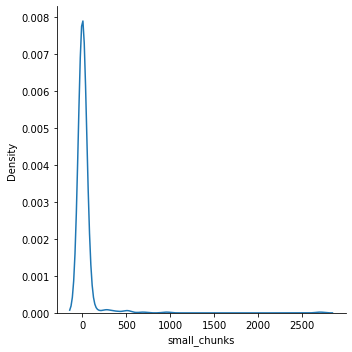

In [11]:
# Small chunks are scarse
sns.displot(df['small_chunks'], kind='kde')

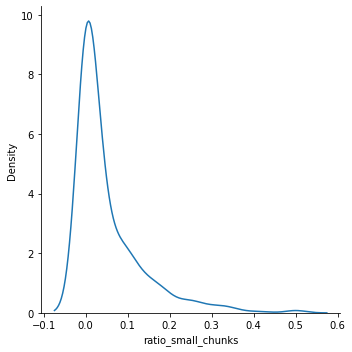

In [12]:
# Small chunks are scarse
sns.displot(df['ratio_small_chunks'], kind='kde')

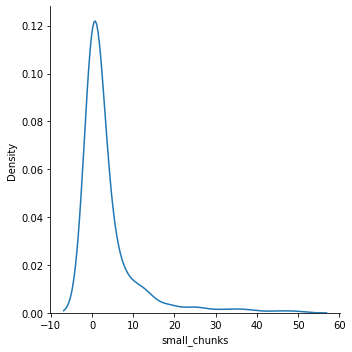

In [13]:
# They are quite rare
sns.displot(df[df['small_chunks'] <= 50]['small_chunks'], kind='kde')

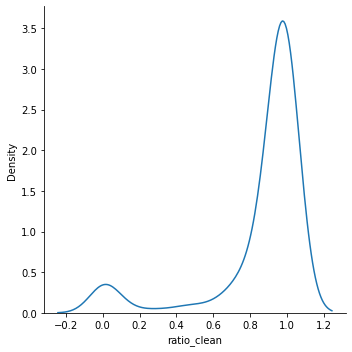

In [14]:
sns.displot(df['ratio_clean'], kind='kde')

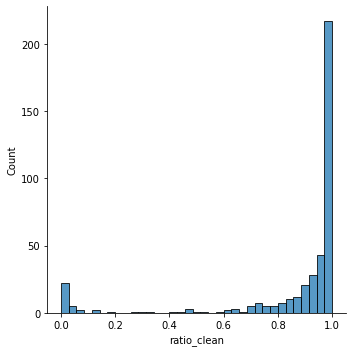

In [15]:
sns.displot(df['ratio_clean'])

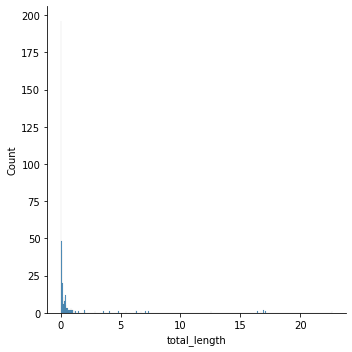

In [16]:
sns.displot(df['total_length'].dt.seconds/3600)

In [17]:
# with good quality
(df[df['ratio_clean'] > 0.5]).shape[0] / df.shape[0]

0.8997555012224939

In [18]:
# % for goog quality length
df[df['ratio_clean'] > 0.5]['total_length'].dt.seconds.sum() / df['total_length'].dt.seconds.sum()

0.8235882219404309

## Taking only good quality segments

In [19]:
df_clean = df[df['ratio_clean'] >= 0.98]
df_clean.head()

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,ratio_clean,ratio_small_chunks
1,../output/res-comp-v0_6/PAT_12/qc_qrs_EEG_297_...,EEG_297,PAT_12,0 days 00:05:42,0 days 00:00:04,0 days 00:05:38,2.0,0.988304,0.023392
2,../output/res-comp-v0_6/PAT_12/qc_qrs_EEG_299_...,EEG_299,PAT_12,0 days 00:02:08,0 days 00:00:00,0 days 00:02:08,0.0,1.000000,0.000000
3,../output/res-comp-v0_6/PAT_12/qc_qrs_EEG_300_...,EEG_300,PAT_12,0 days 00:33:30,0 days 00:00:32,0 days 00:32:58,8.0,0.984080,0.015920
10,../output/res-comp-v0_6/PAT_17/qc_qrs_EEG_259_...,EEG_259,PAT_17,0 days 00:00:22,0 days 00:00:00,0 days 00:00:22,0.0,1.000000,0.000000
11,../output/res-comp-v0_6/PAT_17/qc_qrs_EEG_259_...,EEG_259,PAT_17,0 days 00:00:18,0 days 00:00:00,0 days 00:00:18,0.0,1.000000,0.000000


In [30]:
df_clean['cons'] = df_clean['ecg_qc_file_path'].apply(lambda x: x.replace('res-comp-v0_6', 'cons-v0_6').replace('qc_qrs', 'cons').replace('tse_bi', 'csv').replace('cons_', 'cons_{}_Annotations_'.format(re.search(r'PAT_[0-9]*', x).group(0))))
df_clean.head()

/home/aura-alexis/github/seizure_detection_pipeline/env/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,ratio_clean,ratio_small_chunks,cons
1,../output/res-comp-v0_6/PAT_12/qc_qrs_EEG_297_...,EEG_297,PAT_12,0 days 00:05:42,0 days 00:00:04,0 days 00:05:38,2.0,0.988304,0.023392,../output/cons-v0_6/PAT_12/cons_PAT_12_Annotat...
2,../output/res-comp-v0_6/PAT_12/qc_qrs_EEG_299_...,EEG_299,PAT_12,0 days 00:02:08,0 days 00:00:00,0 days 00:02:08,0.0,1.000000,0.000000,../output/cons-v0_6/PAT_12/cons_PAT_12_Annotat...
3,../output/res-comp-v0_6/PAT_12/qc_qrs_EEG_300_...,EEG_300,PAT_12,0 days 00:33:30,0 days 00:00:32,0 days 00:32:58,8.0,0.984080,0.015920,../output/cons-v0_6/PAT_12/cons_PAT_12_Annotat...
10,../output/res-comp-v0_6/PAT_17/qc_qrs_EEG_259_...,EEG_259,PAT_17,0 days 00:00:22,0 days 00:00:00,0 days 00:00:22,0.0,1.000000,0.000000,../output/cons-v0_6/PAT_17/cons_PAT_17_Annotat...
11,../output/res-comp-v0_6/PAT_17/qc_qrs_EEG_259_...,EEG_259,PAT_17,0 days 00:00:18,0 days 00:00:00,0 days 00:00:18,0.0,1.000000,0.000000,../output/cons-v0_6/PAT_17/cons_PAT_17_Annotat...


In [31]:
import shutil

for src in df_clean['cons'].values:
    dst = src.replace('cons-v0_6', 'cons-v0_6_clean')
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)